In [ ]:
%load_ext jupyter_black

# Benchmarking an algorithm for MAX-k-SAT

We showcase qubrabench by implementing and benchmarking a hillclimbing algorithm for MAX-k-SAT, described in https://arxiv.org/abs/2203.04975.
The paper describes two variants: a normal hillclimber - which uses (quantum) search, and a steep one - which use (quantum) max finding.

## Search and Max Functions

Before we address the problem at hand, it is important to understand the functionality qubrabench provides.

The library includes a set of common functions you would need in various circumstances, for example the search and the max function. These return the result you would expect from other implementations of these functions, and at the same time add in quantum benchmarking functionality. This simultaneously makes it easier to understand the use-cases of the library and makes it relatively easy to adapt existing code to use quantum benchmarking.

When we talk about quantum benchmarking here, we mean approximating the amount of calls needed to execute the function with identical parameters on a quantum computer. This library achieves this by counting the calls run on the classical (in this case most likely your) machine and basing performance assumptions on these measurements. All provided functions in qubrabench currently require a stats object, in which these collected statistics and approximations are stored.

Let's take a look at the docstrings of the functions we will need to solve our problem - search and max.



In [ ]:
from qubrabench.algorithms.search import search as qsearch

%pdoc qsearch

Class docstring:
    Search a list in random order for an element satisfying the given predicate, while keeping track of query statistics.
    
    >>> search([1,2,3,4,5], lambda x: x % 2 == 0, rng=np.random.default_rng(1))
    2
    
    Args:
        iterable: iterable to be searched over
        key: function to test if an element satisfies the predicate
        rng: np.random.Generator instance as source of randomness
        error: upper bound on the failure probability of the quantum algorithm.
        max_classical_queries: maximum number of classical queries before entering the quantum part of the algorithm.
        stats: keeps track of statistics.
    
    Raises:
        ValueError: Raised when the error bound is not provided and statistics cannot be calculated.
    
    Returns:
        An element that satisfies the predicate, or None if no such argument can be found.
Call docstring:
    Call self as a function.

To understand the search implementation, we can have a look at the example provided in the docstring. In this case, we call the search function on an array (iterable) containing numbers one to five. We are searching for an even number, by providing the key function. This function acts as a predicate to classify the iterable entries. Before any search is run, the array passed to the search function is randomly shuffled. This means, that you will receive the same result if you set a specific seed, however by default you will receive different results for each run. In this case using a seed of 1, the found even number is 2, thus we get this as the output of the function call.

In [ ]:
from qubrabench.algorithms.search import search
import numpy as np

search([1, 2, 3, 4, 5], lambda x: x % 2 == 0, rng=np.random.default_rng(1))

2

As we briefly touched on above, we provide a random number generator, in this case the numpy default generator using a seed of 1. This is necessary for testing, to ensure the results will be consistent in cases where this is important. When implementing the hillclimber later, we will also provide the other documented parameters, such as error, max_classical_queries and stats.

In [ ]:
from qubrabench.algorithms.max import max as qmax

%pdoc qmax

Class docstring:
    Find the largest element in a list, while keeping track of query statistics.
    
    Args:
        iterable: iterable to find the maximum in
        default: default value to return if iterable is empty.
        key: function that maps iterable elements to values that are comparable. By default, use the iterable elements.
        error: upper bound on the failure probability of the quantum algorithm.
        stats: object that keeps track of statistics.
    
    Raises:
        ValueError: Raised when the failure rate `error` is not provided and statistics cannot be calculated.
        ValueError: Raised when iterable is an empty sequence and no default is provided.
    
    Returns:
        the desired maximum element
Call docstring:
    Call self as a function.

The following example will use the max function documented above. It may seem a bit confusing, that the values in the array (iterable) should be themselves arrays containing only a single integer, however this will be used here to demonstrate the use of the key function. We provide the max function with the described array and intend to receive the array containing the highest integer. The default value is set to [-1] here, such a value would indicate an empty iterable being passed to the function.

In [ ]:
from qubrabench.algorithms.max import max

max([[14], [2], [30], [7], [91]], default=[-1], key=lambda x: x[0])

[91]

Now that we have a basic understanding of the search and max functions, we can have a closer look at the MAX-k-SAT problem, which we intend to solve using our hillclimber algorithm.

## Problem: MAX-k-SAT

Max-k-SAT is a combinatorial optimization problem that given a list of clauses $(C_{i})^{p}_{i=1}$, each a disjunction of at most $k$ literals, and a set of weights $(w_{i})^{p}_{i=1}$, asks us to maximize the weight of the satisfied clauses,
$$\varphi(y) := \sum ^{p} _{i=1} w_{i}C_{i}(y),$$
over all assignments $y \in \{0, 1\}^{q}$ of the variables. This problem is NP-hard for $k ≥ 2$.

## Algorithm: Hillclimb search

We start with a random assignment $y \in \{0, 1\}^{n}$ and look for improvements in the set of all bitstrings that differ from $y$ in at most $d$ bits.
The simple hill climber randomly samples such assignments until it finds one with a strictly higher value of $\varphi$, which is then taken as the new assignment.
This procedure is repeated until no further improvement is found.
We can formalize each hillclimb step (described above) as searching for a solution in
$$f:N_{d}(y) \subseteq \{0,1\}^{n} →\{0,1\}$$
$$f(z) = \begin{cases}1 ~~~~~\text{if}~ \varphi(z)>\varphi(y)\\ 0 ~~~~~\text{otherwise} \end{cases}$$

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from hillclimber import hill_climber

%psource hill_climber

def hill_climber(
        inst: WeightedSatInstance,
        *,
        rng: np.random.Generator,
        error: Optional[float] = None,
        stats: Optional[QueryStats] = None,
        steep: bool = False,
) -> Optional[Assignment]:
    """A hillclimbing heuristic to find maximizing assignments to weighted SAT instances
        by progressively transitioning to better solutions using neighborhood search.


    Args:
        inst: The SAT instance to be solved.
        rng: Source of randomness
        error: upper bound on the failure probability. Defaults to None.
        stats: Statistics instance keeping track of costs. Defaults to None.
        steep: True when the neighborhood search is performed greedily, otherwise randomly. Defaults to False.

    Returns:
        Optional[Assignment]: The best assignment found by the heuristic.
    """
    if rng is None:
        rng = np.random.default_rng()

    # precompute some matrices (see 4.3.2 in Cade et al)
    n = inst.n
    # gen

As you will notice, we use the search and max functions provided by qubrabench here.

Starting at the top, the hill_climber function generates a random assignment for the weighted sat instance it receives. Continuing to the while loop, the hill climber calculates all neighbours of the current solution. The neighbours are defined as all solutions with a hamming distance of 1 to the current solution. Following this calculation the weight of every neighboring solution is calculated. In this example you can see the results of the calculations described above, for $n=3$, a far lower value than we would realistically use, but much more practical for this demonstration.
$$n=3$$
$$ones = \begin{bmatrix}1 & 1 & 1\\1 & 1 & 1\\1 & 1 & 1\end{bmatrix}$$
$$flip = \begin{bmatrix}-1 & 1 & 1\\1 & -1 & 1\\1 & 1 & -1\end{bmatrix}$$
$$x=\begin{bmatrix}1 & -1 & 1\end{bmatrix}$$
$$neighbours = \begin{bmatrix}-1 & 1 & 1\\1 & -1 & 1\\1 & 1 & -1\end{bmatrix} \cdot \begin{bmatrix}1 & -1 & 1\\1 & -1 & 1\\1 & -1 & 1\end{bmatrix} = \begin{bmatrix}-1 & -1 & 1\\1 & 1 & 1\\1 & -1 & -1\end{bmatrix}$$

Now we get to an important distinction, which will decide, whether we use the search or the max function: if we want to run a steep hill climber or a simple hill climber. The steep hill climber will choose the neighbour with the highest weight, maximising this value in every iteration of the loop. For these cases, we will use max to find the neighbour with the highest weight. If we want to run a simple hill climber, we simply use the search function and choose the first neighbour with a higher weight than that of the current solution.

In both cases we also pass the error and stats parameters to populate the stats for this operation. You are able to see some results the stats objects hold in the next section, where we run the hill climber a few times.

## Benchmarking

The imported `run` function executes the hillclimber on a random instance and returns the statistics in a pandas DataFrame. As running the hillclimber also touches on some important topics on relation to the search and max functions, we will also take a look at its code.

In [ ]:
from hillclimber import run

%psource run

def run(
        k: int,
        r: int,
        n: int,
        *,
        n_runs: int,
        rng: np.random.Generator,
        error: Optional[float] = None,
        random_weights: Optional[Callable[[int], npt.NDArray[W]]] = None,
        steep: bool = False,
) -> pd.DataFrame:
    """External interface to generate weighted sat instances, run the hillclimber algorithm and return statistics.

    Args:
        k: Number of literals in a clause
        r: Factor for the number of clauses
        n: size (variable number) of the SAT instances
        n_runs: number of runs to perform in each group
        rng: Source of randomness
        error: Upper bound on the failure rate. Defaults to None.
        random_weights: Optionally providable weights for SAT instance generation. Defaults to None.
        steep: Whether to perform hillclimb steep (greedily). Defaults to False.

    Returns:
        Dataframe holding benchmarking statistics of the runs performed.
    """
    assert n_run

As you can see, we can run the hillclimber multiple times in this case and then compute the average of the results. In the loop we first generate a QueryStats object, as mentioned above, which is used to store the results of the hillclimber run. After that, we create a problem instance using our desired parameters. Once this is done we can run the hillclimber, providing all possible parameters, including `error`, `stats` and `steep`. In our case we require the stats in a pandas dataframe, which is why we convert the stats object into a dictionary, add some additional interesting stats and add it to the `history` array.

Let's run the simple hill climber for $n = 100$, $n = 300$ and $n=1000$. We will run the hill climber five times for each $n$ and consistently use $k = 3$.

In [ ]:
%%time
data_100 = run(
    k=3,
    r=3,
    n=100,
    n_runs=5,
    rng=np.random.default_rng(seed=100),
    error=10**-5,
    steep=False,
)
data_100

CPU times: user 991 ms, sys: 547 ms, total: 1.54 s
Wall time: 258 ms


,classical_control_method_calls,classical_actual_queries,classical_expected_queries,quantum_expected_classical_queries,quantum_expected_quantum_queries,n,k,r
0,30,323,384.570085,479.512593,1406.328791,100,3,3
1,36,278,401.106644,490.979380,1403.161953,100,3,3
2,34,447,391.413922,479.151696,1403.151044,100,3,3
3,33,450,502.847292,637.243136,1428.630329,100,3,3
4,36,403,465.018820,586.693118,1412.953709,100,3,3


In [ ]:
%%time
data_300 = run(
    k=3,
    r=3,
    n=300,
    n_runs=5,
    rng=np.random.default_rng(seed=100),
    error=10**-5,
    steep=False,
)
data_300

CPU times: user 5.41 s, sys: 2.71 s, total: 8.12 s
Wall time: 1.04 s


,classical_control_method_calls,classical_actual_queries,classical_expected_queries,quantum_expected_classical_queries,quantum_expected_quantum_queries,n,k,r
0,84,1283,1261.721855,1127.550898,2597.460386,300,3,3
1,98,1845,1551.877397,1309.538970,2765.816371,300,3,3
2,107,1555,1462.087551,1266.818224,2693.987783,300,3,3
3,125,1934,1734.345010,1574.608739,2663.159641,300,3,3
4,141,2288,2288.387038,2064.978697,2834.972905,300,3,3


In [ ]:
%%time
data_500 = run(
    k=3,
    r=3,
    n=500,
    n_runs=5,
    rng=np.random.default_rng(seed=100),
    error=10**-5,
    steep=False,
)
data_500

CPU times: user 23.4 s, sys: 11.6 s, total: 35 s
Wall time: 4.48 s


,classical_control_method_calls,classical_actual_queries,classical_expected_queries,quantum_expected_classical_queries,quantum_expected_quantum_queries,n,k,r
0,176,2398,2819.495579,2182.857108,3816.828094,500,3,3
1,177,3376,3232.572225,2406.739172,3978.449335,500,3,3
2,202,4251,4424.741429,3635.369840,4080.164884,500,3,3
3,170,3473,3507.717553,2607.764300,4065.223527,500,3,3
4,169,3136,2913.619514,2375.653554,3765.630163,500,3,3


## Plotting
We use the `PlottingStrategy` wrapper to define our plot parameters and configuration.

In [ ]:
from qubrabench.utils.plotting_strategy import PlottingStrategy


class Plotter(PlottingStrategy):
    def __init__(self):
        self.colors[""] = "blue"

    def get_plot_group_column_names(self):
        return ["k", "r"]

    def get_data_group_column_names(self):
        return []

    def compute_aggregates(self, data, *, quantum_factor):
        # compute combined query costs of quantum search
        c = data["quantum_expected_classical_queries"]
        q = data["quantum_expected_quantum_queries"]
        data["quantum_cost"] = c + quantum_factor * q
        return data

    def x_axis_column(self):
        return "n"

    def x_axis_label(self):
        return "$n$"

    def y_axis_label(self):
        return "Queries"

    def get_column_names_to_plot(self):
        return {
            "classical_actual_queries": ("Classical Queries", "o"),
            "quantum_cost": ("Quantum Queries", "x"),
        }

We can put all the benchmark stats in a single table and run the plotter. 

In [ ]:
%pdoc Plotter.plot

Class docstring:
    Plot benchmarking data.
    
    Args:
        data: a pandas DataFrame containing all the benchmark data.
        quantum_factor: conversion factor for the cost of a quantum query (w.r.t. classical queries).
        y_lower_lim: lower limit on the Y-axis (useful if the data starts at a large value)
    
    Raises:
        ValueError: if no columns are given to plot
Call docstring:
    Call self as a function.

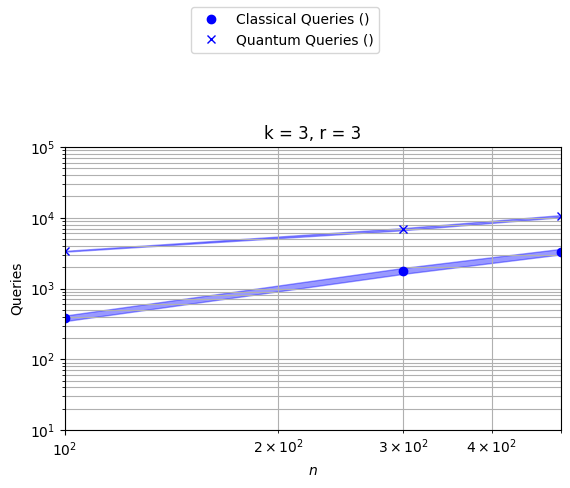

In [ ]:
data = pd.concat([data_100, data_300, data_500])
Plotter().plot(data, quantum_factor=2, y_lower_lim=10)

Now we can also run the "steep" hillclimber for the above instance sizes, and compare the two benchmarks.

In [ ]:
%%time
data_steep = [
    run(
        k=3,
        r=3,
        n=n,
        n_runs=5,
        rng=np.random.default_rng(seed=100),
        error=10**-5,
        steep=True,
    )
    for n in [100, 300, 500]
]
data_steep = pd.concat(data_steep)

CPU times: user 21.4 s, sys: 9.69 s, total: 31.1 s
Wall time: 3.96 s


In [ ]:
# add an extra column to distinguish the source (i.e. type of hillclimb)
full_data = []
for d, is_steep in [(data, False), (data_steep, True)]:
    d = d.copy()
    d.insert(0, "steep", is_steep)
    full_data.append(d)
full_data = pd.concat(full_data)

We modify the above plotter a bit as we now want to group the data by column "steep" (in the same plot).

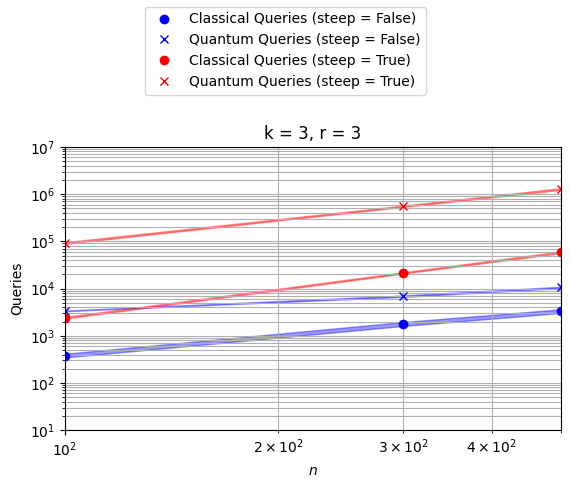

In [ ]:
class FullPlotter(Plotter):
    def __init__(self):
        self.colors["steep = False"] = "blue"
        self.colors["steep = True"] = "red"

    def get_data_group_column_names(self):
        return ["steep"]


FullPlotter().plot(full_data, quantum_factor=2, y_lower_lim=10)